## 任务 1 LSB 隐写算法的基本实现（40 分）

### 1.1 导入依赖库

In [38]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### 1.2 实现信息与二进制编码互相转换

In [39]:
def message_to_bin(message):
    """将消息转为二进制编码"""

    binary = ''.join([format(ord(i), "08b") for i in message])
    return binary

def bin_to_message(binary):
    """将二进制编码转为消息"""

    message = ''.join([chr(int(binary[i:i+8], 2)) for i in range(0, len(binary), 8)])
    return message

### 1.3 实现隐写函数

In [40]:
def hide_message_in_image(image_path, message = None, n_bits=1, save_path=None, binary=None):
    """在灰度图像中使用LSB隐写方法将消息隐藏,支持嵌入任意n位(后 1~4 位)"""

    # 用结束符来标记消息的结束
    delimiter = '1' * (n_bits * 8) + '0' * n_bits

    img = Image.open(image_path).convert('L')
    # 如果提供了binary直接使用，否则将message转为二进制串
    if binary is not None:
        binary_message = binary + delimiter

    else:
        binary_message = message_to_bin(message) + delimiter

    # 将二进制编码分割为 n_bits 位的块
    bit_chunks = [int(binary_message[i:i+n_bits], 2) for i in range(0, len(binary_message), n_bits)]

    data_index = 0
    pixels = np.array(img)
    new_pixels = pixels.copy()
    
    for index, pixel in np.ndenumerate(pixels):
        if data_index < len(bit_chunks):
            # 将原图像的像素值的最后 n_bits 位替换为消息的二进制编码
            mask = ~((1 << n_bits) - 1)
            bits = bit_chunks[data_index]
            new_pixel = (pixel & mask) | bits
            new_pixels[index] = new_pixel
            data_index += 1
        else:
            break
    
    new_img = Image.fromarray(new_pixels, mode='L')
    if save_path:
        new_img.save(save_path)
    return new_pixels, new_img

### 1.4 实现信息提取函数

In [41]:
def extract_message_from_image(image_path, n_bits=1):
    """从灰度图像中提取隐藏的消息"""

    img = Image.open(image_path).convert('L')
    pixels = np.array(img)
    binary_message = ""

    for pixel in np.nditer(pixels):
        # 确保从每个像素提取的消息为 n_bits 位
        binary_message += format(pixel & ((1 << n_bits) - 1), f'0{n_bits}b')
    # 找到结束符，并从该处截断消息
    delimiter = '1' * (n_bits * 8) + '0' * n_bits
    delimiter_index = binary_message.find(delimiter)
    binary_message = binary_message[:delimiter_index]

    return bin_to_message(binary_message)

### 1.5 测试

载入原始图像，分别使用隐写函数和信息提取函数，检验提取的信息是否与原信息一致。

In [42]:
ori_path = "lena.png"
save_path1 = "lena_stego_n1.png"

message = "Hello, My name is R1ck. Welcome to R1ck's Portal! Can you catch the flag?"

_ , img_steg_n1 = hide_message_in_image(ori_path, message, n_bits=1, save_path=save_path1)

extracted_message = extract_message_from_image(save_path1, n_bits=1)

print(f"Extracted message: {message}")

Extracted message: Hello, My name is R1ck. Welcome to R1ck's Portal! Can you catch the flag?


测试嵌入不同的位数时对隐写图像视觉效果的影响

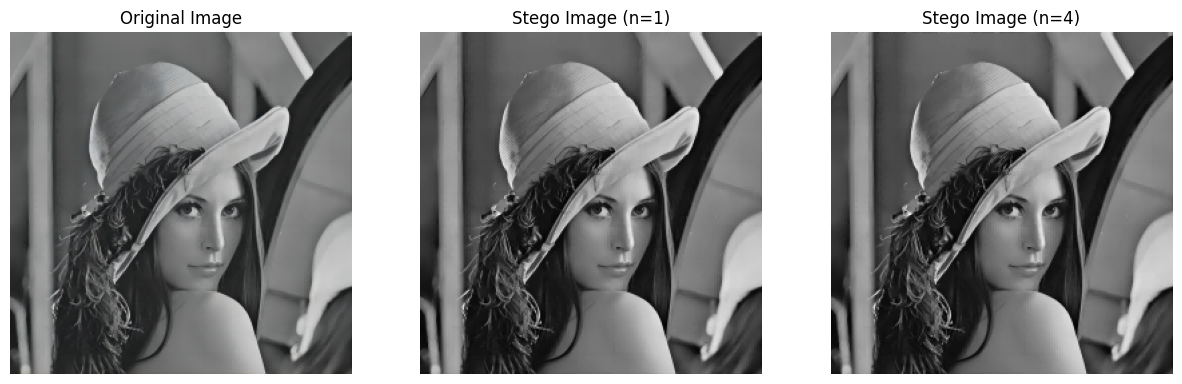

In [43]:
_ , img_steg_n4 = hide_message_in_image(ori_path, message, n_bits=4, save_path="lena_stego_n4.png")

# 展示原图、嵌入1位和嵌入4位的隐写图像
img_ori = Image.open(ori_path)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title("Original Image")
axs[1].set_title("Stego Image (n=1)")
axs[2].set_title("Stego Image (n=4)")

for ax in axs:
    ax.axis('off')

axs[0].imshow(img_ori, cmap='gray')
axs[1].imshow(img_steg_n1, cmap='gray')
axs[2].imshow(img_steg_n4, cmap='gray')

plt.show()


可以发现当我们将消息嵌入在后4位以内时，**图像在视觉上变化不大**

## 任务 2 用卡方分布检测进行隐写分析（20 分）

### 2.1 导入依赖库

In [44]:
! pip install scipy
import random
import string
from scipy.stats import chi2
from scipy.special import gammainc

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Could not fetch URL https://pypi.tuna.tsinghua.edu.cn/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.tuna.tsinghua.edu.cn', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1131)'))) - skipping


### 2.2 比较原图与隐写图像的灰度直方图

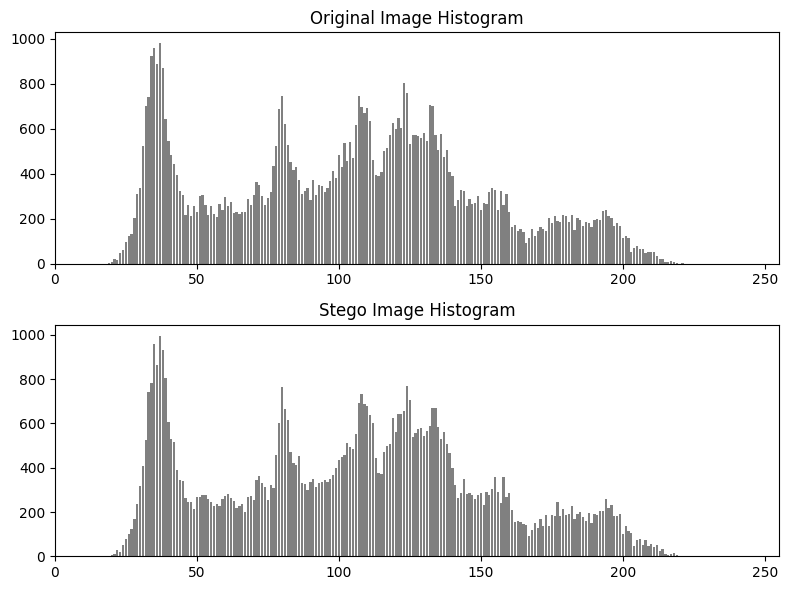

In [45]:
img_ori = cv2.imread(ori_path, cv2.IMREAD_GRAYSCALE)
img_steg_n1 = cv2.imread(save_path1, cv2.IMREAD_GRAYSCALE)

hist_ori = cv2.calcHist([img_ori], [0], None, [256], [0,256]).flatten()
hist_stego = cv2.calcHist([img_steg_n1], [0], None, [256], [0,256]).flatten()

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].bar(range(256), hist_ori, color='gray')
axs[0].set_title('Original Image Histogram')
axs[0].set_xlim([0, 255])

axs[1].bar(range(256), hist_stego, color='gray')
axs[1].set_title('Stego Image Histogram')
axs[1].set_xlim([0, 255])

plt.tight_layout()
plt.savefig("histogram.png")
plt.show()

### 2.3 计算偏差r与载体被隐写的可能性p

2.3.1 使用上一步的隐写图像

In [46]:
def calculate_r_and_p(hist):

    # 初始化卡方值
    r = 0
    k = 0  # 自由度

    # 遍历灰度值对，计算卡方值
    for i in range(0, 256, 2):

        if i + 1 >= 256:
            break
        # 计算每对的像素总数
        pair_total = hist[i] + hist[i + 1]
        if pair_total == 0:
            continue  # 避免除以0
        
        # 计算并累加卡方值
        r += ((hist[i] - hist[i + 1]) ** 2) / pair_total / 2
        k += 1

    # 计算P值
    p = 1 - chi2.cdf(r, k - 1)

    return r, p


r_ori, p_ori = calculate_r_and_p(hist_ori)
r_stego, p_stego = calculate_r_and_p(hist_stego)
print(f"原始图像的r值: {r_ori}, P值: {p_ori}")
print(f"上一步结果的r值: {r_stego}, P值: {p_stego}")


原始图像的r值: 278.7287926756887, P值: 0.0
上一步结果的r值: 254.4245582754773, P值: 2.042810365310288e-14


2.3.2 增加隐写的嵌入率(增加消息长度)，计算偏差r与载体被隐写的可能性p

In [47]:
pix_num = img_ori.shape[0] * img_ori.shape[1]

# 生成长度为图像分辨率1/2的随机二进制编码
binary_half = ''.join(random.choices('01', k=pix_num // 2))

# 生成长度为图像分辨率的随机二进制编码
binary_full = ''.join(random.choices('01', k=pix_num - 9))

img_steg_half_pixels , _ =hide_message_in_image(ori_path, binary=binary_half, n_bits=1)
img_steg_half = img_steg_half_pixels.reshape((img_ori.shape[0], img_ori.shape[1]))
img_steg_full_pixels , _ = hide_message_in_image(ori_path, binary=binary_full, n_bits=1)
img_steg_full = img_steg_full_pixels.reshape((img_ori.shape[0], img_ori.shape[1]))


hist_half = cv2.calcHist([img_steg_half], [0], None, [256], [0,256]).flatten()
hist_full = cv2.calcHist([img_steg_full], [0], None, [256], [0,256]).flatten()

r_half, p_half = calculate_r_and_p(hist_half)
r_full, p_full = calculate_r_and_p(hist_full)

print(f"嵌入率50%时的r值: {r_half}, P值: {p_half}")
print(f"嵌入率100%时的r值: {r_full}, P值: {p_full}")


嵌入率50%时的r值: 125.02725436481597, P值: 0.08880929134196092
嵌入率100%时的r值: 41.16496456543976, P值: 0.9999999971159736


2.4.2 比较不同嵌入率下r和p的变化规律

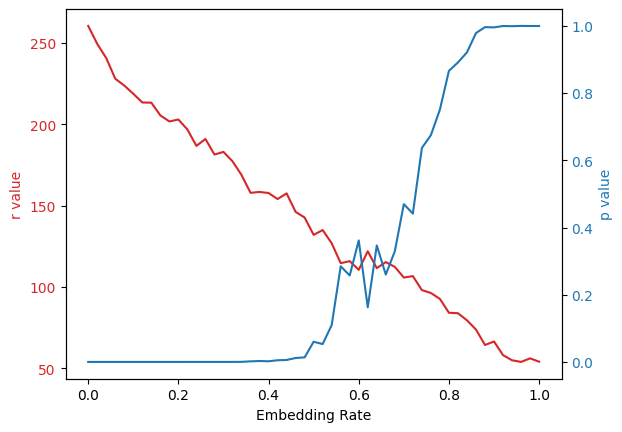

In [48]:
import numpy as np
# 比较嵌入率从0%到100%时的r和p值(间隔2%)
embedding_rates = np.arange(0, 101, 2) / 100

rs = []
ps = []

for rate in embedding_rates:
    r_avg = 0
    p_avg = 0
    for i in range(10):
        binary = ''.join(random.choices('01', k=int(pix_num * rate) - 9))
        img_steg_pixels , _ = hide_message_in_image(ori_path, binary=binary, n_bits=1)
        img_steg = img_steg_pixels.reshape((img_ori.shape[0], img_ori.shape[1]))
        hist_steg = cv2.calcHist([img_steg], [0], None, [256], [0,256]).flatten()
        r , p = calculate_r_and_p(hist_steg)
        r_avg += r
        p_avg += p
        # 计算平均r和p值
        
    rs.append(r_avg / 10)
    ps.append(p_avg / 10)
    

# 创建图表
fig, ax1 = plt.subplots()

# 绘制r值
color = 'tab:red'
ax1.set_xlabel('Embedding Rate')
ax1.set_ylabel('r value', color=color)
ax1.plot(embedding_rates, rs, label='r value', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 使用twinx创建第二个y轴
ax2 = ax1.twinx()  

# 绘制p值
color = 'tab:blue'
ax2.set_ylabel('p value', color=color)
ax2.plot(embedding_rates, ps, label='p value', color=color)
ax2.tick_params(axis='y', labelcolor=color)


## 任务 3：LSB 的改进（20 分）

### 3.1 随机LSB替换

In [49]:
def hide_message_in_image_random(image_path, message=None, n_bits=1, save_path=None, binary=None, seed=42):
    """在灰度图像中使用随机LSB隐写方法将消息隐藏,支持嵌入任意n位(后 1~4 位)"""
    
    # 用结束符来标记消息的结束
    delimiter = '1' * (n_bits * 8) + '0' * n_bits

    img = Image.open(image_path).convert('L')
    # 如果提供了binary直接使用，否则将message转为二进制串
    if binary is not None:
        binary_message = binary + delimiter
    else:
        binary_message = message_to_bin(message) + delimiter

    # 将二进制编码分割为 n_bits 位的块
    bit_chunks = [binary_message[i:i+n_bits] for i in range(0, len(binary_message), n_bits)]

    pixels = np.array(img)
    flat_pixels = pixels.flatten()
    new_pixels = flat_pixels.copy()

    # 设置随机种子以确保过程可重复
    random.seed(seed)

    # 生成随机替换的像素索引
    indices = list(range(len(flat_pixels)))
    random.shuffle(indices)
    indices = indices[:len(bit_chunks)]

    for data_index, pixel_index in enumerate(indices):
        # 获取要嵌入的位
        bits_to_hide = int(bit_chunks[data_index], 2)
        # 将原图像的像素值的最后 n_bits 位替换为消息的二进制编码
        mask = ~((1 << n_bits) - 1)
        new_pixels[pixel_index] = (flat_pixels[pixel_index] & mask) | bits_to_hide

    new_pixels = new_pixels.reshape(pixels.shape)
    new_img = Image.fromarray(new_pixels, mode='L')
    
    if save_path:
        new_img.save(save_path)
        
    return new_pixels, new_img

def extract_message_from_image_random(image_path, n_bits=1, seed=42):
    """从使用随机LSBM算法隐藏信息的灰度图像中提取消息"""
    
    img = Image.open(image_path).convert('L')
    pixels = np.array(img)
    flat_pixels = pixels.flatten()
    binary_message = ""

    # 与隐藏信息时使用相同的随机种子
    random.seed(seed)
    
    # 生成与隐藏时相同的像素索引序列
    indices = list(range(len(flat_pixels)))
    random.shuffle(indices)


    for pixel_index in indices:
        # 提取像素的最低n位
        binary_message += format(flat_pixels[pixel_index] & ((1 << n_bits) - 1), f'0{n_bits}b')
    
    # 找到结束符，并从该处截断消息
    delimiter = '1' * (n_bits * 8) + '0' * n_bits
    delimiter_index = binary_message.find(delimiter)
    binary_message = binary_message[:delimiter_index]

    return bin_to_message(binary_message)

### 3.2 LSBM算法

In [50]:
def LSBM(image_path, message=None, save_path=None, binary=None):
    """在灰度图像中使用随机LSB隐写方法将消息隐藏,支持嵌入任意n位(后 1~4 位)"""
    
    # 用结束符来标记消息的结束
    delimiter = '1' * 8 + '0'

    img = Image.open(image_path).convert('L')
    # 如果提供了binary直接使用，否则将message转为二进制串
    if binary is not None:
        binary_message = binary + delimiter
    else:
        binary_message = message_to_bin(message) + delimiter

    bit_chunks = [binary_message[i:i+1] for i in range(0, len(binary_message))]

    pixels = np.array(img)
    flat_pixels = pixels.flatten()
    new_pixels = flat_pixels.copy()


    for data_index, bit in enumerate(bit_chunks):
        pixel_value = new_pixels[data_index]
        bit_to_hide = int(bit, 2)

        if pixel_value % 2 != bit_to_hide:
            if random.randint(0, 1) == 1:
                # 确保加1后不超过255
                if pixel_value < 255:
                    new_pixels[data_index] += 1
                else:
                    new_pixels[data_index] -= 1
            else:
                # 确保减1后不小于0
                if pixel_value > 0:
                    new_pixels[data_index] -= 1
                else:
                    new_pixels[data_index] += 1


    new_pixels = new_pixels.reshape(pixels.shape)
    new_img = Image.fromarray(new_pixels, mode='L')
    
    if save_path:
        new_img.save(save_path)
        
    return new_pixels, new_img

### 3.3 测试

测试能否从LSBM隐写图像中提取信息

In [51]:
hide_message_in_image_random(ori_path, message, save_path="lena_random.png")
message_extracted_random = extract_message_from_image_random("lena_random.png")
LSBM(ori_path, message, save_path="lena_lsbm.png")
message_extracted_lsbm = extract_message_from_image("lena_lsbm.png")
print(f"Extracted message from random: {message_extracted_random}")
print(f"Extracted message from LSBM: {message_extracted_lsbm}")

Extracted message from random: Hello, My name is R1ck. Welcome to R1ck's Portal! Can you catch the flag?
Extracted message from LSBM: Hello, My name is R1ck. Welcome to R1ck's Portal! Can you catch the flag?


使用隐写分析比较普通LSB算法、随机LSB替换算法和LSBM算法

In [52]:
img_steg_lsb_random , _ =hide_message_in_image_random(ori_path, binary=binary_full)
img_steg_lsb_random = img_steg_lsb_random.reshape((img_ori.shape[0], img_ori.shape[1]))
img_steg_lsbm , _ = LSBM(ori_path, binary=binary_full)
img_steg_lsbm = img_steg_lsbm.reshape((img_ori.shape[0], img_ori.shape[1]))


hist_random = cv2.calcHist([img_steg_lsb_random], [0], None, [256], [0,256]).flatten()
hist_lsbm = cv2.calcHist([img_steg_lsbm], [0], None, [256], [0,256]).flatten()

r_random, p_random = calculate_r_and_p(hist_random )
r_lsbm, p_lsbm = calculate_r_and_p(hist_lsbm )

print(f"普通LSB算法的r值: {r_full}, P值: {p_full}")
print(f"随机LSB替换算法的r值: {r_half}, P值: {p_half}")
print(f"LSBM算法的r值: {r_lsbm}, P值: {p_lsbm}")


普通LSB算法的r值: 41.16496456543976, P值: 0.9999999971159736
随机LSB替换算法的r值: 125.02725436481597, P值: 0.08880929134196092
LSBM算法的r值: 130.45759594176278, P值: 0.04675721664745103
